In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np
import matplotlib.pyplot as plt


duration = 7 * 14
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", 7 * 14),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [2]:
rume.time_frame.end_date

datetime.date(2023, 1, 6)

In [3]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/14week_temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [4]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=Poisson(),
)

filter_type = ParticleFilter(num_particles=500)

In [5]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [6]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

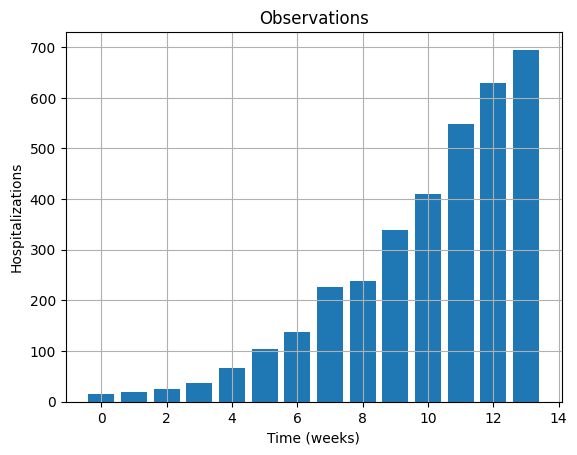

In [7]:
plt.bar(range(len(sim.cases)), sim.cases[:, 0])
plt.title("Observations")
plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalizations")
plt.grid(True)
plt.show()

In [8]:
rng = np.random.default_rng(seed=1)
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2022-12-31 00:00:00 (98 days)
• 500 particles

Simulation completed in 82.24s

Parameters estimated: ['beta', 'xi']


In [9]:
from epymorph.parameter_forecasting.forecast_class import ForecastSiulation


sim = ForecastSiulation(
    initial_particles=output.particles,
    rume=rume,
    params_space=params_space,
    model_link=observations.model_link,
    duration=40,
)

In [10]:
forecast_output, obs_quantiles = sim.run()

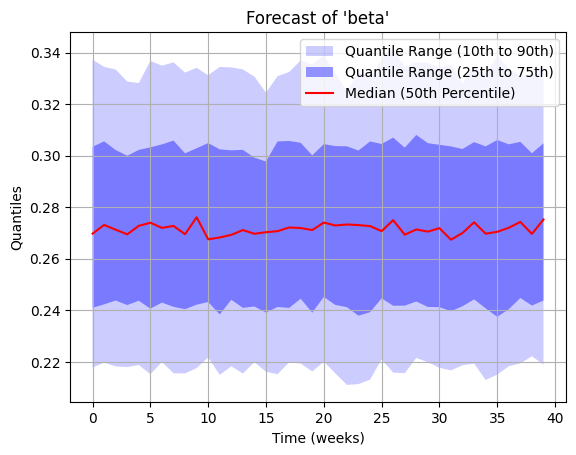

In [ ]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()